In [130]:
import pandas as pd
import matplotlib.pyplot as plt 
from langdetect import detect
import numpy as np

# Créer un exmple de dictionnaire
dictionary = {
    'name1': (5, 'date1', "It is so bad"),
    'name2': (4, 'date2', 'it sucks'),
    'name3': (3, 'date2', "It's okay"),
    'name4': (5, 'date2', 'It is very good'),
    'name5': (5, 'date2', "c'est un peu nul"),
    'name6': (5, 'date2', "Le robot est très bon"),
    'name7': (5, 'date2', "The robot is very good"),
    'name8': (5, 'date2', "El robot es muy bueno"),
    'name9': (5, 'date2', "Il robot è molto buono"),
}

# Convertir le dictionnaire en DataFrame
df = pd.DataFrame(dictionary, index=['grading', 'date', 'Text']).T

df = df.reset_index().rename(columns={"index": "name"})
df = df.reset_index().rename(columns={"index": "ID"})
df.set_index('ID', inplace=True)

# Ajouter la colonne Language à la DataFrame
df['Language'] = df['Text'].apply(detect)

df

,name,grading,date,Text,Language
ID,,,,,
0,name1,5,date1,It is so bad,en
1,name2,4,date2,it sucks,en
2,name3,3,date2,It's okay,tl
3,name4,5,date2,It is very good,en
4,name5,5,date2,c'est un peu nul,ro
5,name6,5,date2,Le robot est très bon,fr
6,name7,5,date2,The robot is very good,en
7,name8,5,date2,El robot es muy bueno,es
8,name9,5,date2,Il robot è molto buono,it


## EDA

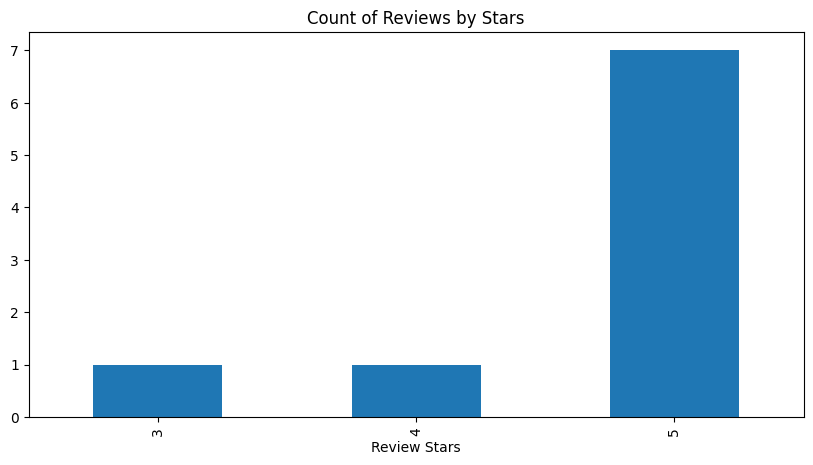

In [131]:
ax = df['grading'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Sentiment Analysis

### Roberta

In [132]:
from transformers import pipeline

In [133]:
# Sentiment Analysis with Roberta

nlp = pipeline("sentiment-analysis", model=f"cardiffnlp/twitter-roberta-base-sentiment")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']
    if langue == 'en':
        dict = pd.DataFrame(nlp(text))
        dict['ID'] = index
        res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res['label'] = res['label'].replace('LABEL_0', 'NEGATIVE')
res['label'] = res['label'].replace('LABEL_1', 'NEUTRAL')
res['label'] = res['label'].replace('LABEL_2', 'POSITIVE')
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={"label": "label (roberta)", "score": "score (roberta)"})
res.set_index('ID', inplace=True)

# Merge the two dataframes
df = df.merge(res, left_index=True, right_index=True, how='left')
df



,name,grading,date,Text,Language,label (roberta),score (roberta)
ID,,,,,,,
0,name1,5,date1,It is so bad,en,NEGATIVE,0.961788
1,name2,4,date2,it sucks,en,NEGATIVE,0.943688
2,name3,3,date2,It's okay,tl,NaN,NaN
3,name4,5,date2,It is very good,en,POSITIVE,0.983293
4,name5,5,date2,c'est un peu nul,ro,NaN,NaN
5,name6,5,date2,Le robot est très bon,fr,NaN,NaN
6,name7,5,date2,The robot is very good,en,POSITIVE,0.981288
7,name8,5,date2,El robot es muy bueno,es,NaN,NaN
8,name9,5,date2,Il robot è molto buono,it,NaN,NaN


### Kaludi/Reviews-Sentiment-Analysis

In [134]:
# Pas de neutral dans le modèle Kaludi
# Ce modèle n'est pas très connu et j'ai pas l'impression qu'il soit très performant
nlp = pipeline("sentiment-analysis", model=f"Kaludi/Reviews-Sentiment-Analysis")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']
    if langue == 'en':
        dict = pd.DataFrame(nlp(text))
        dict['ID'] = index
        res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={"label": "label (rev)", "score": "score (rev)"})
res.set_index('ID', inplace=True)

# Merge the two dataframes
df = df.merge(res, left_index=True, right_index=True, how='left')
df


,name,grading,date,Text,Language,label (roberta),score (roberta),label (rev),score (rev)
ID,,,,,,,,,
0,name1,5,date1,It is so bad,en,NEGATIVE,0.961788,Negative,0.977560
1,name2,4,date2,it sucks,en,NEGATIVE,0.943688,Negative,0.526841
2,name3,3,date2,It's okay,tl,NaN,NaN,NaN,NaN
3,name4,5,date2,It is very good,en,POSITIVE,0.983293,Positive,0.950893
4,name5,5,date2,c'est un peu nul,ro,NaN,NaN,NaN,NaN
5,name6,5,date2,Le robot est très bon,fr,NaN,NaN,NaN,NaN
6,name7,5,date2,The robot is very good,en,POSITIVE,0.981288,Positive,0.959777
7,name8,5,date2,El robot es muy bueno,es,NaN,NaN,NaN,NaN
8,name9,5,date2,Il robot è molto buono,it,NaN,NaN,NaN,NaN


## nlptown/bert-base-multilingual-uncased-sentiment

In [135]:
# Sentiment Analysis Bert-base-uncased
# Plusieurs langages disponibles (dont le français)
#English	150k
#Dutch	80k
#German	137k
#French	140k
#Italian	72k
#Spanish
# Il classifie les phrases en étoiles (1 à 5)
# Ce modèle est connu

nlp = pipeline("sentiment-analysis", model=f"nlptown/bert-base-multilingual-uncased-sentiment")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']
    if langue == 'en' or langue == 'fr' or langue == 'es' or langue == 'it' or langue == 'de' or langue == 'nl':
        dict = pd.DataFrame(nlp(text))
        dict['ID'] = index
        res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res['label'] = res['label'].replace('1 star', int(1))
res['label'] = res['label'].replace('2 stars', int(2))
res['label'] = res['label'].replace('3 stars', int(3))
res['label'] = res['label'].replace('4 stars', int(4))
res['label'] = res['label'].replace('5 stars', int(5))
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={"label": "label (Bert), over 5", "score": "score (Bert)"})
res.set_index('ID', inplace=True)

# Merge the two dataframes
df = df.merge(res, left_index=True, right_index=True, how='left')
df


,name,grading,date,Text,Language,label (roberta),score (roberta),label (rev),score (rev),"label (Bert), over 5",score (Bert)
ID,,,,,,,,,,,
0,name1,5,date1,It is so bad,en,NEGATIVE,0.961788,Negative,0.977560,1.0,0.716054
1,name2,4,date2,it sucks,en,NEGATIVE,0.943688,Negative,0.526841,1.0,0.630184
2,name3,3,date2,It's okay,tl,NaN,NaN,NaN,NaN,NaN,NaN
3,name4,5,date2,It is very good,en,POSITIVE,0.983293,Positive,0.950893,5.0,0.463786
4,name5,5,date2,c'est un peu nul,ro,NaN,NaN,NaN,NaN,NaN,NaN
5,name6,5,date2,Le robot est très bon,fr,NaN,NaN,NaN,NaN,5.0,0.501968
6,name7,5,date2,The robot is very good,en,POSITIVE,0.981288,Positive,0.959777,5.0,0.462739
7,name8,5,date2,El robot es muy bueno,es,NaN,NaN,NaN,NaN,5.0,0.511576
8,name9,5,date2,Il robot è molto buono,it,NaN,NaN,NaN,NaN,4.0,0.457357


## Comparaison des modèles